❓We load some time serie model

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import requests
url="https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly_champagne_sales.csv"
s=requests.get(url).content
df=pd.read_csv(io.StringIO(s.decode('utf-8')))

❓We transform the `Month` column into a time var using [`to_datetime`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html). We can then reindex by the `Month` column

In [41]:
df["Month"] = pd.to_datetime(df["Month"], infer_datetime_format=True)
df = df.set_index(df["Month"])
df = df.drop("Month", axis=1)
df.head()

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


❓Well done, thanks to this "reindexing", you should now be able to plot the `Sales` (y-axis) as a function of the time (x-axis).

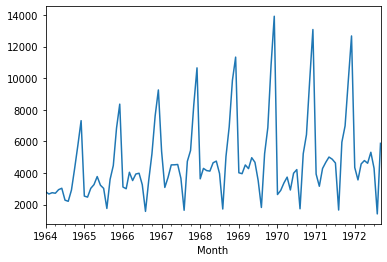

In [42]:
df["Sales"].plot();

❓We split data into training/testing set

In [43]:
import numpy as np

index = df.index
train_indexes = np.where(index < pd.datetime.strptime("1972", "%Y"))[0]
test_indexes = np.where(index >= pd.datetime.strptime("1972", "%Y"))[0]

df_train = df.iloc[train_indexes]
df_test = df.iloc[test_indexes]

In [44]:
print("train shape: {}, test shape: {}".format(df_train.shape,df_test.shape))

train shape: (96, 1), test shape: (9, 1)


We will now fit a non linear model such as a random forest. The idea is to predict a value using previous ones. 

You will try to create new columns in `df` that are the previous valus of `df['Sales']` historically. 

❓You can use the `shift` function to create 12 new features corresponding to 12 shifts from 1 month to 12 months. This is gonna be our training features (the 12 previous values)

In [45]:
# Add lagged values

df["x_1"] = df["Sales"].shift(1)
df["x_2"] = df["Sales"].shift(2)
df["x_3"] = df["Sales"].shift(3)
df["x_4"] = df["Sales"].shift(4)
df["x_5"] = df["Sales"].shift(5)
df["x_6"] = df["Sales"].shift(6)
df["x_7"] = df["Sales"].shift(7)
df["x_8"] = df["Sales"].shift(8)
df["x_9"] = df["Sales"].shift(9)
df["x_10"] = df["Sales"].shift(10)
df["x_11"] = df["Sales"].shift(11)
df["x_12"] = df["Sales"].shift(12)

We created a testing function to evaluate performance over our dataset. 

It takes 
- the true y values (`ytrue` which should be a Numpy array), 
- the indexes of the test samples (`test_indexes`), 
- the predictor (`estimator`: your model) 
- the training set (our shifted columns) `training_set`, which should be a Numpy array

In [56]:
# For each predictor, design a method to evaluate its performance on the test set:
def evaluate_performance_month_prediction_lm_rf(ytrue, test_indexes, estimator, training_set):

    ypred = []
    ytest = []
    
    for idx in test_indexes:

        current_Xtest = training_set[idx,:]
        current_ytest = ytrue[idx]
        
        current_Xtrain = training_set[:idx]
        current_ytrain = ytrue[:idx]
        
        estimator.fit(current_Xtrain, current_ytrain)
        prediction = estimator.predict(current_Xtest.reshape(1,-1))
        
        ypred.append(prediction[0])
        ytest.append(current_ytest)

    rmse = np.sqrt(mean_squared_error(ytest, ypred))
    return ytest, ypred, rmse

❓Let's train a Random Forest a model over those 12 features that we just created

In [80]:
new_features = df[["x_1","x_2","x_3","x_4","x_5","x_6","x_7","x_8","x_9","x_10","x_11","x_12"]].fillna(0).values

In [81]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=20, random_state=0)

In [82]:
results_rf = evaluate_performance_month_prediction_lm_rf(ytrue=df["Sales"].values, test_indexes=test_indexes,
                                                         estimator=random_forest, training_set = new_features)

In [83]:
results_rf

([4348, 3564, 4577, 4788, 4618, 5312, 4298, 1413, 5877],
 [3897.55,
  3588.75,
  4014.05,
  4506.75,
  4746.25,
  4381.05,
  4124.8,
  2186.95,
  7421.3],
 706.8323176523394)

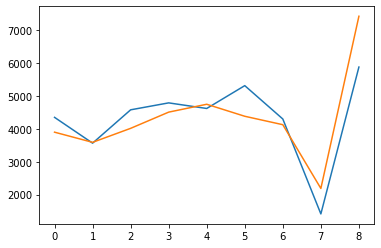

In [61]:
plt.plot(results_rf[0])
plt.plot(results_rf[1])

To improve our model, we can do some feature engineering. First, [let's add moving average using `rolling`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html).

We create 3 new columnns in `df`: 
1. one which is the rolling average of `df[Sales]` with a window of 12, 
2. one with a window of 3, and one with a window of 2 

This will have the effect to isolate the trend (on top of cycles) and allow the algorithm to learn it. 

In [71]:
df['ma_12'] = df['Sales'].rolling(window=12).mean()
df['ma_3'] = df['Sales'].rolling(window=3).mean()
df['ma_2'] = df['Sales'].rolling(window=2).mean()

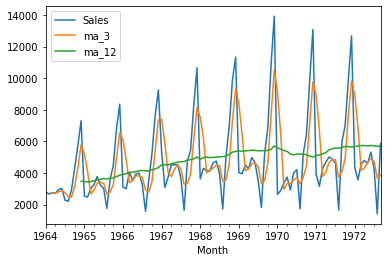

In [72]:
df[["Sales","ma_3", "ma_12"]].plot()

❓You can also add a more smoothing predictor using the exponential moving average (hint: [method `.ewm` with `halflife` of 2, 3 and 12](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html)), that statistically optimizes an autoregressive process. 

In [73]:
df["ewma_2"] = df["Sales"].ewm(halflife=2).mean()
df["ewma_3"] = df["Sales"].ewm(halflife=3).mean()
df["ewma_12"] = df["Sales"].ewm(halflife=12).mean()

❓Let's plot these new features

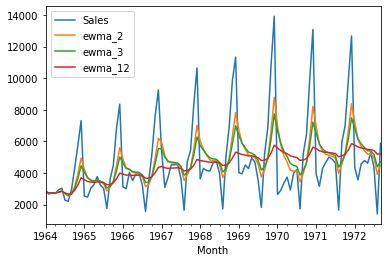

In [74]:
df[["Sales", "ewma_2", "ewma_3", "ewma_12"]].plot()

In [77]:
random_forest = RandomForestRegressor(n_estimators=20, random_state=12)

new_features = df[["ewma_2", "ewma_3", "ewma_12", "ma_2", "ma_3", "ma_12", "x_1","x_2","x_3","x_4","x_5",
                   "x_6","x_7","x_8","x_9","x_10","x_11","x_12"]].fillna(0).values

results_rf = evaluate_performance_month_prediction_lm_rf(ytrue=df["Sales"].values, test_indexes=test_indexes,
                                                         estimator=random_forest, training_set = new_features)

In [78]:
results_rf

([4348, 3564, 4577, 4788, 4618, 5312, 4298, 1413, 5877],
 [4516.2,
  3891.9,
  4377.15,
  4640.05,
  4778.75,
  4947.8,
  4468.65,
  2497.95,
  6846.95],
 527.3794759626759)

You should see a better RMSE!

❓Try to look at the importance of each feature. What do you find?


In [65]:
importances = random_forest.feature_importances_

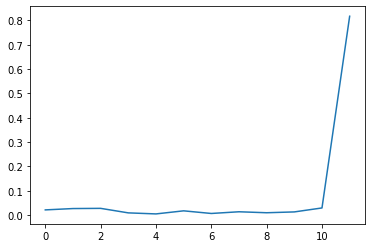

In [66]:
plt.plot(importances)

In [85]:
new_features

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [2815.,    0.,    0., ...,    0.,    0.,    0.],
       [2672., 2815.,    0., ...,    0.,    0.,    0.],
       ...,
       [5312., 4618., 4788., ..., 5951., 1659., 4633.],
       [4298., 5312., 4618., ..., 6981., 5951., 1659.],
       [1413., 4298., 5312., ..., 9851., 6981., 5951.]])